## Extract measurement list from S3

In [6]:
import sys
sys.path.append('/Users/joy.chen/insitroRepos/posh_internal/common_utils') ## Adding path to common utils
sys.path.append('/Users/joy.chen/insitroRepos/posh_internal/core')


%load_ext autoreload
%autoreload 2

In [7]:
import math
import numpy as np
from matplotlib import pyplot as plt
from insitro_core.pyxcell.utils import data, plate, microscope
from third_party_utils.filesystem.parquet_file import ParquetFile
from pandera.typing import DataFrame
#Read image and detect harris corners 
import seaborn as sns
import cv2 as cv
from scipy.spatial import KDTree

import os
from datetime import date 
import pandas as pd
import database_utils as db_utils
import image_utils as img_utils
from PIL import Image, ImageOps
from insitro_core.pyxcell.type_definitions import (
    AffineAdjustDataFrameSchema, 
    CanonicalPlateAcquisition,
    CanonicalPlateDataFrameSchema
)
from skimage import exposure,filters,measure,segmentation

In [8]:
from insitro_core.pyxcell.utils import image, data, fluorescence, microscope
from insitro_core.pyxcell.type_definitions import ImageWithNamedChannels
from insitro_core.pyxcell.modules.segmentation import viz
from insitro_core.pyxcell.modules.segmentation.segmenters import cellpose_public
from insitro_core.pyxcell.modules.sequencing import fcn_base_caller, qc
from insitro_core.pyxcell.pipelines import registration

2023-08-20 15:21:26,418 [INFO] WRITING LOG OUTPUT TO /Users/joy.chen/.cellpose/run.log


In [10]:
plate_id = 'AR001'
microscope_id = 'nikon1_pyxscope'

                                  

number_of_cycles = 1

output_bucket = 's3://insitro-microscopy-data/prod/pyxcell'
output_dir = os.path.join(output_bucket,plate_id)
output_dir
#acqusition dataframe for ISS
list_of_measurementsDF = data.get_canonical_acquisitions(plate_id)
list_of_measurementsDF

2023-08-20 15:23:26,227 [INFO] Found credentials in shared credentials file: ~/.aws/credentials


,microscope_label,plate_barcode,measurement_id,measurement_datetime,total_images,channels
0,nikon2_pyxscope,AR001,9a09725d-3935-44df-92bc-3fdadf2832f4,2023-03-15 01:30:33.534090,1500,[UV-None-Penta]
1,nikon2_pyxscope,AR001,e70353a9-575d-4a91-a256-cb6703d3365b,2023-03-15 01:47:52.512224,1500,[UV-None-Penta]
2,nikon4_pyxscope,AR001,88502283-d776-44b3-93c7-92ca0e59e830,2023-06-05 22:12:22.619504,60,[UV-Widefield]
3,nikon4_pyxscope,AR001,27b4a749-ba3b-4d4b-83f5-d1e9cc888fa3,2023-06-13 15:32:53.172053,3,[GFP]
4,nikon4_pyxscope,AR001,d3b8721f-95d8-4999-b1ce-e2ba4bc6a5a2,2023-06-13 15:37:27.051858,3,[GFP]
5,nikon4_pyxscope,AR001,3fa60eff-375c-49f3-9f1d-f5e5a701c986,2023-06-13 16:49:04.870984,3,[GFP]
6,nikon1_pyxscope,AR001,da3d9cba-9861-4e58-8fb6-6d26d11b33a6,2023-06-21 16:02:48.103743,540,[argolight]
7,nikon1_pyxscope,AR001,4b501939-5a93-4779-ac04-3889dfc6c1a7,2023-06-21 16:17:38.429376,756,[argolight]
8,nikon4_pyxscope,AR001,5e789522-ef6c-4ac0-af0d-91cfeb49e17a,2023-06-21 20:51:44.680198,756,[argolight]
9,nikon4_pyxscope,AR001,67c0d1b2-859c-4141-abfd-16e1384f1773,2023-06-21 21:06:11.893799,756,[argolight]


In [11]:
#Specify the data acquired.
argolight_data = list_of_measurementsDF[(list_of_measurementsDF['measurement_datetime'] > '2023-08-18')]

In [12]:
argolight_data

,microscope_label,plate_barcode,measurement_id,measurement_datetime,total_images,channels
42,nikon1_pyxscope,AR001,d8152de4-9731-4a27-ac4f-e038f848aead,2023-08-18 15:44:01.758762,36,"[posh_a, posh_c, posh_g, posh_nucleus, posh_t]"
43,nikon1_pyxscope,AR001,7034dfc7-a45c-40d3-a696-be0006559f72,2023-08-18 16:51:19.721462,36,"[posh_a, posh_c, posh_g, posh_nucleus, posh_t]"
44,nikon1_pyxscope,AR001,39be4005-5937-44fe-ba31-3dd57db51036,2023-08-18 17:58:35.538009,36,"[posh_a, posh_c, posh_g, posh_nucleus, posh_t]"
45,nikon1_pyxscope,AR001,bf82af92-0daf-4e9c-ab44-5361ecf9f152,2023-08-18 19:00:38.721923,36,"[posh_a, posh_c, posh_g, posh_nucleus, posh_t]"
46,nikon1_pyxscope,AR001,529b8439-20a6-4734-a8b7-642a19208d2c,2023-08-18 20:09:07.051479,36,"[posh_a, posh_c, posh_g, posh_nucleus, posh_t]"
47,nikon1_pyxscope,AR001,60fd2f34-3e9f-4f67-bda0-cdb69a329d66,2023-08-18 21:19:22.549302,36,"[posh_a, posh_c, posh_g, posh_nucleus, posh_t]"
48,nikon1_pyxscope,AR001,c4a21515-c302-4dfe-bd7c-42c01884bb50,2023-08-18 21:52:11.534499,36,"[posh_a, posh_c, posh_g, posh_nucleus, posh_t]"


In [13]:
list_of_measurements = argolight_data[argolight_data['microscope_label'] == microscope_id]['measurement_id'].values
acquisition_df = data.create_multi_acquisition_canonical_dataframe(list_of_measurements)
acquisition_df

,id,microscope_id,measurement_id,file_path,raw_image_file_paths,time_index,plane_index,field_index,plate_barcode,well_row,...,measurement_datetime,observation_datetime,created_at_1,last_updated_at_1,exposure_time_milliseconds,index,channel_index,source_metadata_file_path,quadralateral_shearing_interferometry_modality_settings_id,well_loc
0,18190426,4,d8152de4-9731-4a27-ac4f-e038f848aead,s3://insitro-microscopy-data/prod/canonical/6d...,[s3://insitro-microscopy-nikon-archive/nikon1/...,0,0,0,AR001,1,...,2023-08-18 15:44:03.803762,2023-08-18 15:44:03.803762,2023-08-18 15:58:29.342492,None,350.001456,4,4,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01
1,18190426,4,d8152de4-9731-4a27-ac4f-e038f848aead,s3://insitro-microscopy-data/prod/canonical/6d...,[s3://insitro-microscopy-nikon-archive/nikon1/...,0,0,0,AR001,1,...,2023-08-18 15:44:03.212762,2023-08-18 15:44:03.212762,2023-08-18 15:58:29.342491,None,250.000515,3,3,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01
2,18190426,4,d8152de4-9731-4a27-ac4f-e038f848aead,s3://insitro-microscopy-data/prod/canonical/6d...,[s3://insitro-microscopy-nikon-archive/nikon1/...,0,0,0,AR001,1,...,2023-08-18 15:44:02.189762,2023-08-18 15:44:02.189762,2023-08-18 15:58:29.342489,None,100.003971,2,2,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01
3,18190426,4,d8152de4-9731-4a27-ac4f-e038f848aead,s3://insitro-microscopy-data/prod/canonical/6d...,[s3://insitro-microscopy-nikon-archive/nikon1/...,0,0,0,AR001,1,...,2023-08-18 15:44:02.604762,2023-08-18 15:44:02.604762,2023-08-18 15:58:29.342487,None,150.004441,1,1,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01
4,18190426,4,d8152de4-9731-4a27-ac4f-e038f848aead,s3://insitro-microscopy-data/prod/canonical/6d...,[s3://insitro-microscopy-nikon-archive/nikon1/...,0,0,0,AR001,1,...,2023-08-18 15:44:01.758762,2023-08-18 15:44:01.758762,2023-08-18 15:58:29.342482,None,50.003500,0,0,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,18190720,4,529b8439-20a6-4734-a8b7-642a19208d2c,s3://insitro-microscopy-data/prod/canonical/ae...,[s3://insitro-microscopy-nikon-archive/nikon1/...,12,0,3,AR001,1,...,2023-08-18 20:09:41.611479,2023-08-18 20:09:41.611479,2023-08-18 20:53:48.178747,None,350.001456,4,4,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A02
1256,18190720,4,529b8439-20a6-4734-a8b7-642a19208d2c,s3://insitro-microscopy-data/prod/canonical/ae...,[s3://insitro-microscopy-nikon-archive/nikon1/...,12,0,3,AR001,1,...,2023-08-18 20:09:41.019479,2023-08-18 20:09:41.019479,2023-08-18 20:53:48.178745,None,250.000515,3,3,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A02
1257,18190720,4,529b8439-20a6-4734-a8b7-642a19208d2c,s3://insitro-microscopy-data/prod/canonical/ae...,[s3://insitro-microscopy-nikon-archive/nikon1/...,12,0,3,AR001,1,...,2023-08-18 20:09:40.092479,2023-08-18 20:09:40.092479,2023-08-18 20:53:48.178744,None,100.003971,2,2,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A02
1258,18190720,4,529b8439-20a6-4734-a8b7-642a19208d2c,s3://insitro-microscopy-data/prod/canonical/ae...,[s3://insitro-microscopy-nikon-archive/nikon1/...,12,0,3,AR001,1,...,2023-08-18 20:09:40.475479,2023-08-18 20:09:40.475479,2023-08-18 20:53:48.178742,None,150.004441,1,1,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A02


In [25]:
acquisition_df = acquisition_df.drop_duplicates(subset='file_path', keep='last')

print("there are {} images across {} wells from {} measurements".format( 
    len(acquisition_df.file_path.unique()),len(acquisition_df.well_loc.unique()),
    len(acquisition_df.measurement_id.unique())))

df = acquisition_df.drop_duplicates(subset='measurement_id', keep="first")[['measurement_id', 'measurement_datetime']]
ordered_measurement = list(df.sort_values('measurement_datetime')['measurement_id'])
display(ordered_measurement)

there are 252 images across 4 wells from 7 measurements


['d8152de4-9731-4a27-ac4f-e038f848aead',
 '7034dfc7-a45c-40d3-a696-be0006559f72',
 '39be4005-5937-44fe-ba31-3dd57db51036',
 'bf82af92-0daf-4e9c-ab44-5361ecf9f152',
 '529b8439-20a6-4734-a8b7-642a19208d2c',
 '60fd2f34-3e9f-4f67-bda0-cdb69a329d66',
 'c4a21515-c302-4dfe-bd7c-42c01884bb50']

In [26]:
for measurement in ordered_measurement:
    print(measurement)

d8152de4-9731-4a27-ac4f-e038f848aead
7034dfc7-a45c-40d3-a696-be0006559f72
39be4005-5937-44fe-ba31-3dd57db51036
bf82af92-0daf-4e9c-ab44-5361ecf9f152
529b8439-20a6-4734-a8b7-642a19208d2c
60fd2f34-3e9f-4f67-bda0-cdb69a329d66
c4a21515-c302-4dfe-bd7c-42c01884bb50


## Focusdrive and Focusmaintainer

In [30]:
posh_c_df = acquisition_df.loc[acquisition_df['channel_index'] == 4]

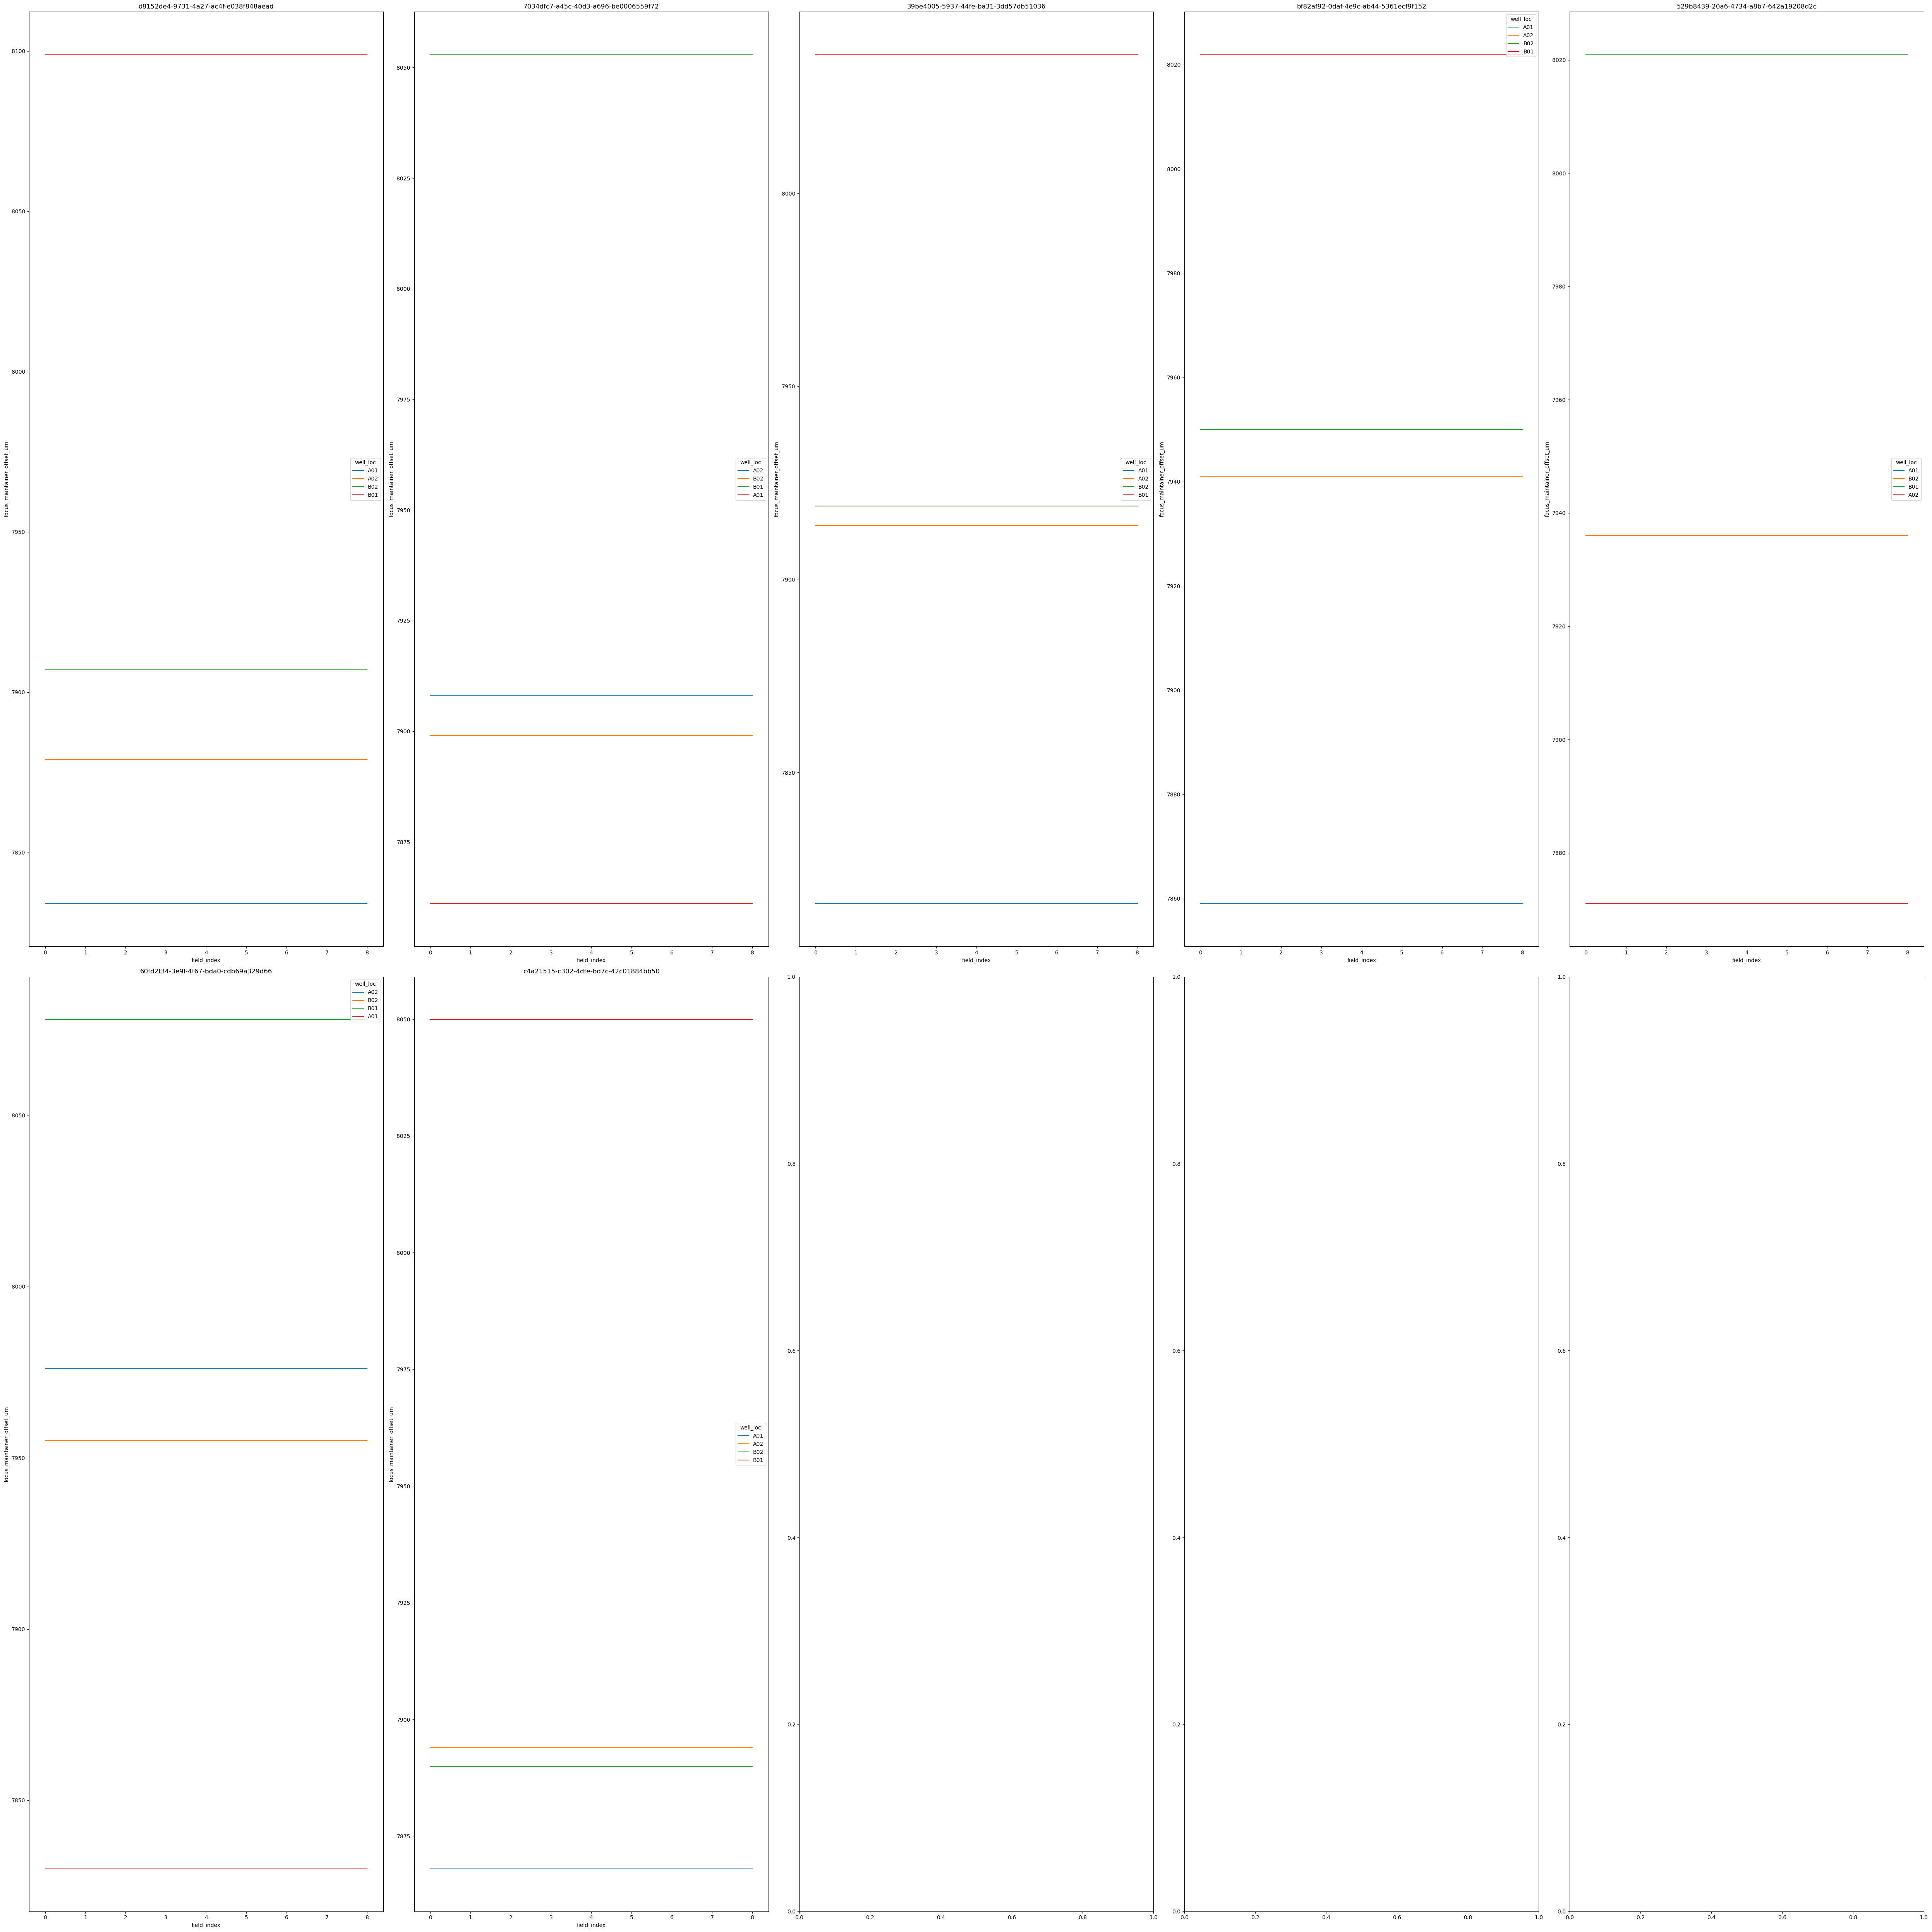

In [33]:
measurements = posh_c_df['measurement_id'].unique()
cols = 5
rows = len(measurements)//cols +1
fig,ax = plt.subplots(ncols=cols,nrows=rows, figsize=(50,50))
for i, measurement in enumerate(measurements):
    row = i//cols
    col = i%cols
    features_subset = posh_c_df[posh_c_df['measurement_id']==measurement]
    sns.lineplot(x = 'field_index', y = 'focus_maintainer_offset_um', hue='well_loc',
            data = features_subset, ax=ax[row][col]),
    ax[row][col].set_title(measurement)      
plt.tight_layout()   

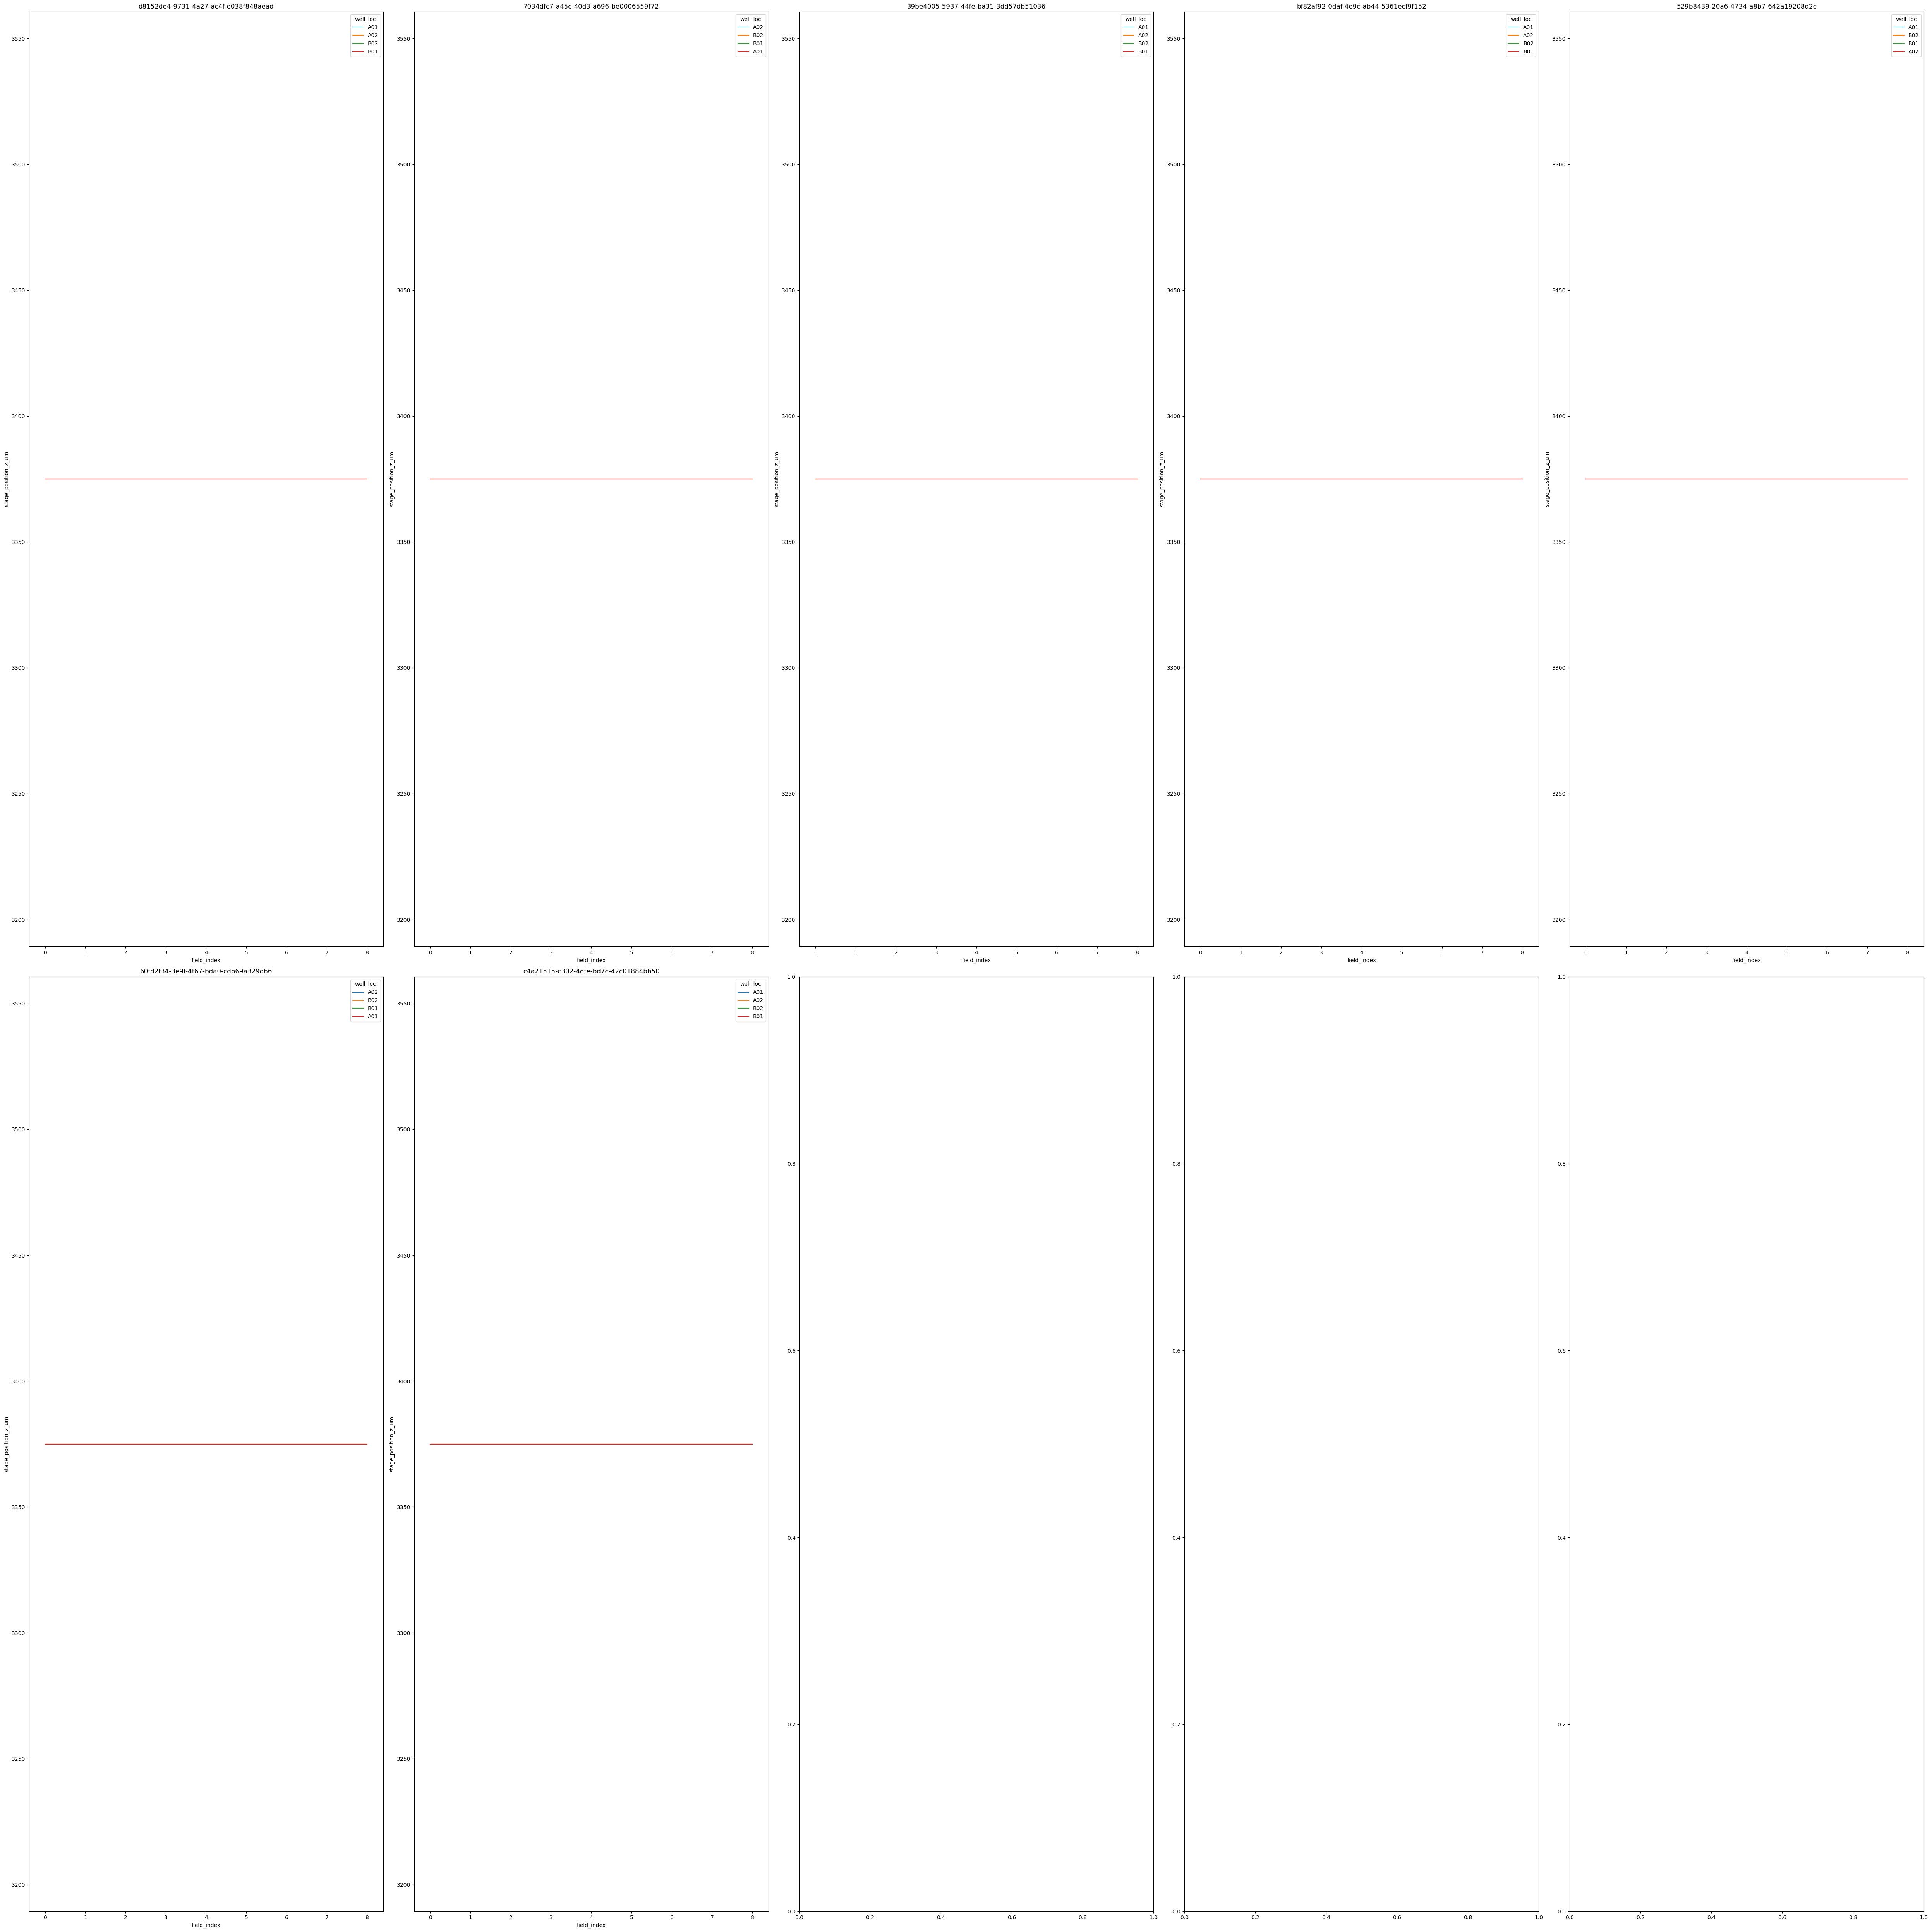

In [34]:
measurements = posh_c_df['measurement_id'].unique()
cols = 5
rows = len(measurements)//cols +1
fig,ax = plt.subplots(ncols=cols,nrows=rows, figsize=(50,50))
for i, measurement in enumerate(measurements):
    row = i//cols
    col = i%cols
    features_subset = posh_c_df[posh_c_df['measurement_id']==measurement]
    sns.lineplot(x = 'field_index', y = 'stage_position_z_um', hue='well_loc',
            data = features_subset, ax=ax[row][col]),
    ax[row][col].set_title(measurement)      
plt.tight_layout()  

#Doesn't show the real z stage position since read_true_stage_positions_during_acquisition is off...

## Download the image from S3

In [14]:
###Change these fields#####

#argolight_measurement_id = '7efe28b8-7938-40b8-94f3-d500e3098860' #Charmander
#argolight_measurement_id = '4e80be8e-d552-4b1f-b597-e096917b32bd' #Charmander 07/19/2023
#argolight_measurement_id = 'c7674bc7-f52b-4e5e-b982-41233ed62dfd' #Charmander 07/21/2023
#argolight_measurement_id = 'ba122adc-79bc-4f4f-8f7c-f29212850495' #Charmander 07/25/2023
#argolight_measurement_id = 'de59a6d1-9afd-4d8d-b1d3-311af2e123f9' #Bulbasaur 07/14/2023
#argolight_measurement_id = '99a6c85d-c735-4246-8688-f27e46d09ca1' #Bulbasaur 07/21/2023
#argolight_measurement_id = 'a824b39a-a1dc-423c-a8e2-94f0c6cb66b3' #Bulbasaur 07/31/2023
argolight_measurement_id = '0d4fa47c-57bc-45d1-95de-6f24c5919854' #Bulbasaur 07/31/2023
#argolight_measurement_id = 'a2462228-c7c9-412a-ba8b-305dc477481d' #Squirtle 07/21/2023
#argolight_measurement_id = 'b00e87c2-fdd3-4480-8e8d-2f7b38566e45' #Squirtle 07/24/2023
#orientation = "N" #Squirtle 07/24/2023
#orientation = "W" #N,W,S,E
orientation = "N"
microscope_name = "bulbasaur"
ref_channel = 1 #Set this to 1 for Squirtle and Charmander for now
##############

In [15]:
today =date.today()
date_today = today.strftime("%Y-%m-%d")
#image_list = pd.DataFrame()
#for measurement in ordered_measurement:
df = data.create_acquisition_dataframe(argolight_measurement_id) 
df = plate.standardize_column_mappings(df, microscope.SourceMicroscope.NIKON_1_CANONICAL)
#image_list = pd.concat(df2, ignore_index = True)

In [16]:
channel_names = df['channel_name'].unique()
channel_indices = df['channel_index'].unique()
channel_index_to_name = {}
for i, channel_index in enumerate(channel_indices):
    channel_index_to_name[channel_index] = channel_names[i] 

In [20]:
#!aws s3 cp '{df.raw_image_file_paths[0][0]}' .
fname = os.path.basename(df.raw_image_file_paths[0][0])
image = Image.open(fname)
tags = image.tag_v2

In [21]:
def npy_to_tif(df, img_dir, well_locs, plane_ids, fov_ids, tags):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)    
    for well_loc in well_locs:
        well_dir = os.path.join(img_dir, well_loc)
        if not os.path.exists(well_dir):
            os.mkdir(well_dir)
        for fov_id in fov_ids:
            fov_dir = os.path.join(well_dir, str(fov_id))
            if not os.path.exists(fov_dir):
                os.mkdir(fov_dir)
            for plane_id in plane_ids:
                plane_dir = os.path.join(fov_dir, str(plane_id))
                if not os.path.exists(plane_dir):
                    os.mkdir(plane_dir)

                img_s3_location = df[(df['well_loc'] == well_loc) \
                                     & (df['field_id'] == fov_id) \
                                     & (df['plane_id'] == plane_id)].path.values[0]

                img = data.read_image(img_s3_location, data.ImageStorageFormat.CHW)

                #Split each image by channel and save as tif 
                num_channels = img.shape[0]

                print("Saving to directory:", plane_dir)

                for i in range(num_channels):
                    img_channel = Image.fromarray(img[i,:,:])
                    #img_channel = Image.fromarray(np.uint16((img[i,:,:]/np.max(img[i,:,:]))*((2**16)-1)))
                    img_channel.save(os.path.join(plane_dir, 'channel_'+ str(i) + '.tif') \
                                     ,tiffinfo = tags) #Tif saved with tags
    

In [ ]:
#The Argolight dot pattern is in well A01
img_dir = f'argolight_{microscope_name}'
well_locs = ['A01']
plane_ids = [0]
fov_ids = [0]

if len(well_locs) == 1:
    !rm -r {img_dir}/{well_locs[0]}/{plane_ids[0]}/{fov_ids[0]}
npy_to_tif(df, img_dir, well_locs, plane_ids, fov_ids, tags) 

In [22]:
#The Argolight intensity reponse is in well B02
img_dir = f'argolight_{microscope_name}'
well_locs = ['B02']
plane_ids = [0]
fov_ids = [0]

if len(well_locs) == 1:
    !rm -r {img_dir}/{well_locs[0]}/{plane_ids[0]}/{fov_ids[0]}
npy_to_tif(df, img_dir, well_locs, plane_ids, fov_ids, tags)  

rm: argolight_bulbasaur/B02/0/0: No such file or directory
2023-08-20 15:26:24,264 [INFO] Found credentials in shared credentials file: ~/.aws/credentials
Saving to directory: argolight_bulbasaur/B02/0/0


## Field Uniformity

In [42]:
from PIL import Image

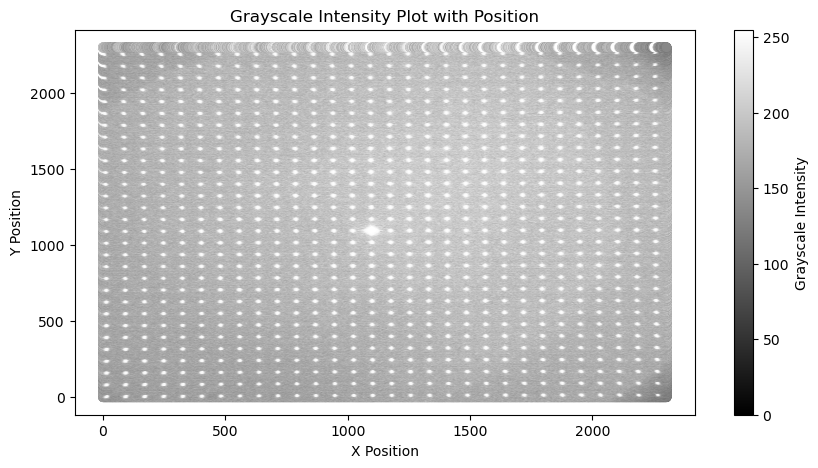

In [53]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from PIL import Image
def measure_grayscale_intensity(image_path):
    #Convert the image to grayscale
    #image = Image.open(image_path).convert("L")
    pixels = image.load()
    width, height = image.size
    intensity_values = []
    x_positions = []
    y_positions = []
    for y in range(height):
        for x in range(width):
            intensity_values.append(pixels[x, y])
            x_positions.append(x)
            y_positions.append(y)
    return x_positions, y_positions, intensity_values
image_path = "/Users/joy.chen/Desktop/POSH/Microscope/argolight_bulbasaur/A01/0/0/channel_1.tif"
x_positions, y_positions, intensity_values = measure_grayscale_intensity(image_path)
plt.figure(figsize=(10, 5))
plt.scatter(x_positions, y_positions, c=intensity_values, cmap='gray', norm=Normalize(vmin=0, vmax=255))
plt.colorbar(label='Grayscale Intensity')
plt.title('Grayscale Intensity Plot with Position')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()

## Intensity Reponse

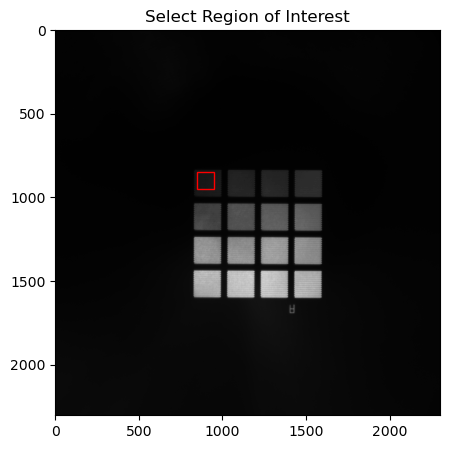

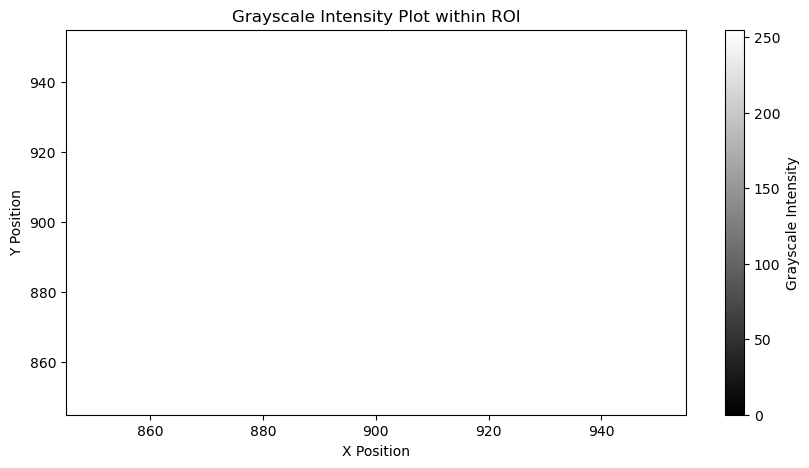

In [30]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
from PIL import Image
def measure_grayscale_intensity(image, x1, y1, x2, y2):
    pixels = image.load()
    intensity_values = []
    x_positions = []
    y_positions = []
    for y in range(y1, y2 + 1):
        for x in range(x1, x2 + 1):
            intensity_values.append(pixels[x, y])
            x_positions.append(x)
            y_positions.append(y)
    return x_positions, y_positions, intensity_values

# input image path
image_path = "/Users/joy.chen/Desktop/POSH/Microscope/argolight_bulbasaur/B02/0/0/channel_0.tif"  

#Convert the image to grayscale
image = Image.open(image_path).convert("L")
image_array = plt.imread(image_path)


plt.figure(figsize=(10, 5))
plt.title('Select Region of Interest')


plt.imshow(image_array, cmap='gray')
current_ax = plt.gca()
# Choose the region to measure the grayscale
roi = Rectangle((850, 850), 100, 100, color='red', fill=False)
current_ax.add_patch(roi)


def update_roi(event):
    if roi.get_width() > 0 and roi.get_height() > 0:
        plt.close()

# Connect the update function to the figure's button_press_event
plt.gcf().canvas.mpl_connect('button_press_event', update_roi)
plt.show()

# Extract the coordinates of the selected ROI
x1, y1 = int(roi.get_x()), int(roi.get_y())
x2, y2 = int(roi.get_x() + roi.get_width()), int(roi.get_y() + roi.get_height())

# Measure and plot intensity values within ROI
x_positions, y_positions, intensity_values = measure_grayscale_intensity(image, x1, y1, x2, y2)
plt.figure(figsize=(10, 5))
plt.scatter(x_positions, y_positions, c=intensity_values, cmap='gray', norm=Normalize(vmin=0, vmax=255))
plt.colorbar(label='Grayscale Intensity')
plt.title('Grayscale Intensity Plot within ROI')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()





In [69]:
def corners_to_centroids(img, corners):
    img_fg = np.zeros(img.shape, dtype=np.uint8)
    # Create a binary image where the location of 
    # corner is set to 1, otherwise 0
    x = corners[:,0]
    y = corners[:,1]
    img_fg[y,x] = 255
    img_fg = np.uint8(img_fg)
    
    # Dilate the image so that the remaining black
    # area is guaranteed to be background 
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
    img_bg = cv.dilate(img_fg,kernel,iterations = 3)
    
    #The unknown area of the argolight dot should be 
    #somewhere between known foreground and 
    #known background
    img_unknown = cv.subtract(img_bg,img_fg)
    
    # Create markers from known foreground area
    ret, markers = cv.connectedComponents(img_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # mark the region of unknown with zero
    markers[img_unknown==255] = 0
    img_8bit = cv.cvtColor((img/256).astype('uint8'), cv.COLOR_GRAY2BGR)
    
    markers = cv.watershed(img_8bit,markers)
    #Now that we have segmented the area of the 
    #dot, let's get it's centroid 
    
    #Set the watershed line and background to zero
    markers = markers + 1
    markers[markers<=2] = 0 
    markers[markers>2] = 255
    markers = markers.astype(np.uint8)
    
    output = cv.connectedComponentsWithStats(
	markers, 8, cv.CV_16U)
    (numLabels, labels, stats, centroids) = output
    
    centroid_fg = centroids[1:]
    
    return centroid_fg, markers, stats

In [9]:
centroids_list = []
corners_list = []
markers_list = []
margin = 40
offset = 10
for i in range(5):
    img = cv.imread(os.path.join(img_dir,str(well_locs[0]),str(plane_ids[0]),str(fov_ids[0]),'channel_'+str(i)+'.tif'),-1)
    mask = np.ones(img.shape,dtype=np.uint8)*255
    mask[0:margin,:] = 0
    mask[:,0:margin] = 0
    mask[mask.shape[0]-margin:mask.shape[0],:] = 0
    mask[:,mask.shape[0]-margin:mask.shape[0]] = 0
    center = np.array([img.shape[0]/2, img.shape[1]/2])
    mask = cv.rectangle(mask,np.array([center[0]-margin+offset,center[1]-margin+offset]).astype(int),np.array([center[0]+margin+offset, center[1]+margin+offset]).astype(int),0, thickness=-1)
    img_float = np.float32(img)
    corners = cv.goodFeaturesToTrack(img_float,1000,0.01,20, mask=mask, blockSize=9, useHarrisDetector = False)
    corners = np.squeeze(np.int32(corners),axis=1)
    centroids = corners_to_centroids(img, corners)  
    centroids_list.append(centroids)
    corners_list.append(corners)

In [10]:
affine_matrix = {
    'ref_channel':[],
    'target_channel':[],
    'ref_channel_index':[],
    'target_channel_index':[],
    'a':[],
    'b':[],
    'c':[],
    'd':[],
    'tx':[],
    "ty":[],
    "image_orientation":[] #Orientation Delta between Argolight acquisition and Sample acquisition
}

In [11]:
centroid_ref , markers_ref, _ = centroids_list[ref_channel]
tree = KDTree(centroid_ref)

for i in range(5):
    if i != ref_channel:
        centroid_target, markers_target , _ = centroids_list[i]
        closest_distances, closest_indices = tree.query(centroid_target)

        to_points = centroid_ref[closest_indices]
        from_points = centroid_target

        #RANSAC based outlier rejection 
        #Randomly select 3 pairs of corresponding points
        #Fit an affine matrix
        #Choose the affine matrix with the maximum number of inliers 
        affine_mat, inliers = cv.estimateAffine2D(from_points, to_points, refineIters=10, method=cv.RANSAC,ransacReprojThreshold=1)

        affine_matrix['ref_channel'].append(str(channel_index_to_name[ref_channel]))
        affine_matrix['ref_channel_index'].append(int(ref_channel))
        affine_matrix['target_channel'].append(str(channel_index_to_name[i]))
        affine_matrix['target_channel_index'].append(int(i))
        affine_matrix['a'].append(affine_mat[0][0])
        affine_matrix['b'].append(affine_mat[0][1])
        affine_matrix['c'].append(affine_mat[1][0])
        affine_matrix['d'].append(affine_mat[1][1])
        affine_matrix['tx'].append(affine_mat[0][2])
        affine_matrix['ty'].append(affine_mat[1][2])
        affine_matrix['image_orientation'].append(orientation)


In [12]:
affine_matrix_df = pd.DataFrame.from_dict(affine_matrix)

In [13]:
affine_matrix_df

,ref_channel,target_channel,ref_channel_index,target_channel_index,a,b,c,d,tx,ty,image_orientation
0,posh_g,posh_nucleus,1,0,0.999539,2.972388e-05,0.000012,0.999476,2.892417,1.489876,W
1,posh_g,posh_t,1,2,0.999961,-2.477925e-07,-0.000010,0.999961,1.412185,1.221578,W
2,posh_g,posh_a,1,3,1.000459,-1.630470e-05,-0.000013,1.000441,-0.096992,-0.162462,W
3,posh_g,posh_c,1,4,1.000738,-1.759558e-06,-0.000007,1.000711,-1.087493,-0.569246,W


In [14]:
affine_dataframe_path = os.path.join("s3://insitro-microscopy-data/prod/pyxcell", 
                                 df.plate_id.unique()[0],
                                 'argolight_custom',
                                 argolight_measurement_id,
                                 "chromatic_aberration_transforms.pq")
affine_parameters_dataframe_file = ParquetFile[AffineAdjustDataFrameSchema](
        affine_dataframe_path, schema=AffineAdjustDataFrameSchema
    )
affine_parameters_dataframe_file.write_pandas(DataFrame[AffineAdjustDataFrameSchema](affine_matrix_df))